## Quantum Measurement Classification with Mixed States on Ten Classes MNIST with quantum-enhanced Fourier features, comparison with ZZFM using Spr correlation

Diego Useche

## GPU

In [1]:
#!nvidia-smi

## Libraries

In [2]:
!pip install tensorcircuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 8.5 MB/s eta 0:00:00


In [3]:
from functools import partial
import numpy as np
import tensorflow as tf
import tensorcircuit as tc
from tensorcircuit import keras
import math
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [4]:
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

In [5]:
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score

print(tf.__version__)
print(tf.config.list_logical_devices())

2.17.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


## Utils functions

In [6]:
# this function takes the number of classes and of qubits of the qmc pure, and extract the indices
# of the bit strings that correpond to the classes prediction
## Example, qmc prediction bit string ["00", "01", "10", "11"]
## the classes prediction is encoded in ["00", "10"], then it returns [0, 2]

def _indices_qubits_classes(num_qubits_param, num_classes_param):
  num_qubits_classes_temp = int(np.ceil(np.log2(num_classes_param)))
  a = [np.binary_repr(i, num_qubits_param) for i in range(2**num_qubits_param)]
  b = [(np.binary_repr(i, num_qubits_classes_temp) + "0"*(num_qubits_param - num_qubits_classes_temp)) for i in range(num_classes_param)]
  indices_temp = []
  for i in range(len(a)):
    if a[i] in b:
      indices_temp.append(i)

  return indices_temp

_indices_qubits_classes(4, 4)

[0, 4, 8, 12]

In [7]:
def kernel_density_classification(X_train_param, Y_train_oh_param, X_test_param, gamma_param = 2**(-2)):

  ## Initialize values
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  kde_temp = []
  for j in range(num_classes_temp):
    kde_temp.append(KernelDensity(kernel='gaussian', bandwidth=sigma_temp).fit(X_train_param[Y_train_oh_param[:, j].astype(bool)]))
  ## Prediction
  for j in range(num_classes_temp):
    Y_pred_temp[:, j] =  (Y_train_oh_param[:, j].sum()/len(Y_train_oh_param))*np.exp(kde_temp[j].score_samples(X_test_param))

  return Y_pred_temp

## MNIST Data Set

In [8]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

In [9]:
# Select the indices for the binary classification
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
y_train_oh = tf.reshape (tf.keras.backend.one_hot(y_train, 10), (-1,10))
y_test_oh = tf.reshape (tf.keras.backend.one_hot(y_test, 10), (-1,10))

X_train.shape, X_test.shape, y_train_oh.shape, y_test_oh.shape

((60000, 28, 28, 1),
 (10000, 28, 28, 1),
 TensorShape([60000, 10]),
 TensorShape([10000, 10]))

## Model 1: Mixed QMC variational, QEFF, with Le-Net Conv layer with HEA, Discriminative then generative learning

The number of parameters of the Hardware efficient ansatz is given by,


```
HEA_size = n_qubits * (num_layers_hea + 1) * 2
```



In [10]:
### Quantum variational KDC with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)

class VQKDC_MIXED_QEFF_HEA_LENET:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, dim_lenet_out_param,  input_dim_param, gamma, n_training_data, reduction = "none", training_type = "generative", num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, random_state = 15, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.dim_lenet_out = dim_lenet_out_param
        self.input_dim = input_dim_param
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.reduction  = reduction
        self.training_type = training_type
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.qeff_weights = tf.random.normal((self.dim_lenet_out, int(self.num_ffs*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.num_ffs - 1), dtype=tf.dtypes.float64, seed = random_state)

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        ## build the Let-net model
        self.model = Sequential()
        self.model.add(tf.keras.layers.Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(self.input_dim, self.input_dim, 1)))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(5, 5), padding="same", activation='relu'))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=84, activation='relu'))
        self.model.add(tf.keras.layers.Dense(units=30, activation = 'relu')) # original "softmax"
        self.model.add(tf.keras.layers.Dense(units=self.dim_lenet_out, activation = None))  ## we add this additional layer compared to normal models

        # add the quantum layer

        self.model.add(layer)
        print(self.model.summary())

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = _indices_qubits_classes(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights))[0]
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2 + init_qubit_param, target_qubit_param + init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in reversed(range(1, self.n_qeff_qubits + 1)):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_qeff_qubits):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        if self.training_type == "discriminative":
          measurements_results = measurements_results / tf.reduce_sum(measurements_results, axis = -1)
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
      ## code generated with the aid of chat gpt
      """
      Compute the categorical cross-entropy loss with mean reduction.

      Args:
      y_true: Tensor of true labels, shape (batch_size, num_classes).
      y_pred: Tensor of predicted probabilities, shape (batch_size, num_classes).

      Returns:
      Scalar tensor representing the mean loss over the batch.
      """
      # Ensure predictions are clipped to avoid log(0)
      epsilon_two = 1e-7  # small constant to avoid division by zero
      y_pred = tf.clip_by_value(y_pred, epsilon_two, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon

      # Compute the categorical cross-entropy loss for each sample
      loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

      if self.reduction == "none":
        return loss
      elif self.reduction == "mean":
        # Compute the mean loss over the batch
        mean_loss = tf.reduce_mean(loss)
        return mean_loss
      elif self.reduction == "sum":
        # Compute the sum loss over the batch
        sum_loss = tf.reduce_sum(loss)
        return sum_loss
      else:
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.Adam,
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_lenet_out/2.)*\
          self.model.predict(x_test)).numpy()

    def extract_lenet_features(self, x_test):
      r"""
      Method to extract the features of the Lenet.

      Args:
          x_test:

      Returns:
          Features of the Lenet.
      """
      extract = Model(self.model.inputs, self.model.layers[-2].output)
      new_model = Sequential()
      new_model.add(extract)
      return new_model.predict(x_test)

    def freeze_lenet(self):
      r"""
      Method to frezze the layers of the Lenet.

      Args:
          self:

      Returns:
          None.
      """
      for layer in self.model.layers[:-1]:
          layer.trainable = False

    def set_training_type(self, new_training_type):
      r"""
      Method to change the training type of the method during training.

      Args:
          new_training_strategy:

      Returns:
          None.
      """
      self.training_type = new_training_type

In [11]:
class VQKDC_MIXED_QEFF_HEA:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, reduction = "none", training_type = "generative", num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, random_state = 15, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.reduction  = reduction
        self.training_type = training_type
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.qeff_weights = tf.random.normal((dim_x_param, int(self.num_ffs*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.num_ffs - 1), dtype=tf.dtypes.float64, seed = random_state)

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = _indices_qubits_classes(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights))[0]
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2 + init_qubit_param, target_qubit_param + init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in reversed(range(1, self.n_qeff_qubits + 1)):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_qeff_qubits):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        if self.training_type == "discriminative":
          measurements_results = measurements_results / tf.reduce_sum(measurements_results, axis = -1)
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
      ## code generated with the aid of chat gpt
      """
      Compute the categorical cross-entropy loss with mean reduction.

      Args:
      y_true: Tensor of true labels, shape (batch_size, num_classes).
      y_pred: Tensor of predicted probabilities, shape (batch_size, num_classes).

      Returns:
      Scalar tensor representing the mean loss over the batch.
      """
      # Ensure predictions are clipped to avoid log(0)
      epsilon_two = 1e-7  # small constant to avoid division by zero
      y_pred = tf.clip_by_value(y_pred, epsilon_two, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon

      # Compute the categorical cross-entropy loss for each sample
      loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

      if self.reduction == "none":
        return loss
      elif self.reduction == "mean":
        # Compute the mean loss over the batch
        mean_loss = tf.reduce_mean(loss)
        return mean_loss
      elif self.reduction == "sum":
        # Compute the sum loss over the batch
        sum_loss = tf.reduce_sum(loss)
        return sum_loss
      else:
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.Adam,
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()

In [12]:
## training the quantum circuit
# Define a LeNet CNN feature extraction model
input_shape = X_train.shape[1:]
INPUT_DIM = input_shape[0]
NUM_QUBITS_FFS = 4 ## originally N_QEFFS = 16
NUM_CLASSES = 10
NUM_CLASSES_QUBITS = 4
DIM_LENET_OUT = 4 # originally 16
GAMMA = 2**(-2) ## originally 2**(0)
EPOCHS = 4
N_TRAINING_DATA = X_train.shape[0]
BATCH_SIZE = 16
LEARNING_RATE = 0.0005 ## originally 0.0005
RANDOM_STATE_QEFF = 123
NUM_ANCILLA_QUBITS = 1
NUM_TOTAL_QUBITS = NUM_QUBITS_FFS + NUM_ANCILLA_QUBITS + NUM_CLASSES_QUBITS
NUM_LAYERS_HEA = int(np.round(((2**NUM_TOTAL_QUBITS-1)/NUM_TOTAL_QUBITS)-1))
TRAINING_TYPE = "generative"
REDUCTION = "none"

In [13]:
## this code creates a discriminative model
vqkdc_qeff_hea_lenet = VQKDC_MIXED_QEFF_HEA_LENET(n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, dim_lenet_out_param = DIM_LENET_OUT, input_dim_param = INPUT_DIM, gamma=GAMMA, n_training_data = N_TRAINING_DATA,  reduction = REDUCTION, training_type = TRAINING_TYPE, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, random_state = RANDOM_STATE_QEFF, auto_compile = False)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
vqkdc_qeff_hea_lenet.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
vqkdc_qeff_hea_lenet.fit(X_train, y_train_oh, epochs = EPOCHS)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 20)          │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          25,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 7, 7, 50)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2450)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │         205,884 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ quantum_layer (QuantumLayer)         │ (None, 10)                  │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,154 (922.58 KB)

 Trainable params: 235,154 (922.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1262s 225ms/step - accuracy: 0.6537 - loss: 1.2042
Epoch 2/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 865s 231ms/step - accuracy: 0.9764 - loss: 0.1864
Epoch 3/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 922s 231ms/step - accuracy: 0.9861 - loss: 0.0875
Epoch 4/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 934s 234ms/step - accuracy: 0.9896 - loss: 0.0622


In [14]:
# Create a model only for feature extraction with intermediate sigmoid activation
extract = tf.keras.Model(vqkdc_qeff_hea_lenet.model.inputs, vqkdc_qeff_hea_lenet.model.layers[-2].output)
print(extract.summary())

X_train_feats = extract.predict(X_train)
X_test_feats = extract.predict(X_test)

X_train_feats.shape, X_test_feats.shape

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 20)          │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          25,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 7, 7, 50)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2450)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │         205,884 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 234,128 (914.56 KB)

 Trainable params: 234,128 (914.56 KB)

 Non-trainable params: 0 (0.00 B)

None
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


((60000, 4), (10000, 4))

In [15]:
## create uniform points around the space of data for out-of-distribution density estimation and select gamma for such ds

np.random.seed(3)
X_uniform_feats = np.random.uniform(X_train_feats.min(axis=0), X_train_feats.max(axis=0), size=(10000, 4))
sigma_temp = (1/16)*((X_train_feats.max(axis=0)- X_train_feats.min(axis=0)).max())
gamma_temp = 2**int(np.log2(1/(2*(sigma_temp**2))))

X_uniform_feats.shape, X_train_feats.max(axis=0), X_train_feats.min(axis=0), X_uniform_feats[:2, :], gamma_temp

((10000, 4),
 array([3.190092 , 1.6823162, 3.779599 , 2.5991642], dtype=float32),
 array([-2.346287 , -2.3931928, -2.4682612, -1.7734871], dtype=float32),
 array([[ 0.70313898,  0.49287002, -0.6507291 ,  0.46018392],
        [ 2.59740584,  1.25965774, -1.68362178, -0.86728624]]),
 2)

In [16]:
del extract
del vqkdc_qeff_hea_lenet

In [17]:
import gc

# Call garbage collector
gc.collect()

710

In [18]:
## training the VQKDC quantum circuit with features in a generative way
vqkdc_qeff_hea = VQKDC_MIXED_QEFF_HEA(dim_x_param = NUM_QUBITS_FFS, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, reduction = REDUCTION, gamma=GAMMA, training_type = TRAINING_TYPE, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE)
vqkdc_qeff_hea.fit(X_train_feats, y_train_oh, epochs = EPOCHS)

Epoch 1/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1347s 174ms/step - accuracy: 0.6566 - loss: 3.1093
Epoch 2/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 656s 175ms/step - accuracy: 0.9835 - loss: 2.3588
Epoch 3/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 675s 173ms/step - accuracy: 0.9839 - loss: 2.3480
Epoch 4/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 684s 174ms/step - accuracy: 0.9844 - loss: 2.3437


In [19]:
print(vqkdc_qeff_hea.model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ quantum_layer_1 (QuantumLayer)       │ (16, 10)                    │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,080 (24.06 KB)

 Trainable params: 1,026 (8.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,054 (16.04 KB)

None


In [20]:
y_pred_test = vqkdc_qeff_hea.predict(X_test_feats)
y_pred_uniform = vqkdc_qeff_hea.predict(X_uniform_feats)

accuracy_score(y_test, np.argmax(y_pred_test, axis=1)), y_pred_uniform.shape, y_pred_test.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step


(0.9791, (10000, 10), (10000, 10))

In [21]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values by using the class priors
y_pred_kdc_test = kernel_density_classification(X_train_feats, y_train_oh, X_test_feats, gamma_param = gamma_temp)

spearman_corr_classes = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes[i] = spearmanr(y_pred_test[:, i], y_pred_kdc_test[:, i])[0]*(y_train_oh_array[:, i].sum()/len(y_train_oh_array))

spearman_corr_classes, spearman_corr_classes.sum()

(array([0.07428166, 0.08220345, 0.04944471, 0.04936005, 0.08926186,
        0.06899417, 0.08339989, 0.0525269 , 0.08419455, 0.07469226]),
 0.7083594944846362)

In [23]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values by using the class priors
y_pred_kdc_uniform = kernel_density_classification(X_train_feats, y_train_oh, X_uniform_feats, gamma_param = gamma_temp)

spearman_corr_classes_uniform = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes_uniform[i] = spearmanr(y_pred_uniform[:, i], y_pred_kdc_uniform[:, i])[0]*(y_train_oh_array[:, i].sum()/len(y_train_oh_array))

spearman_corr_classes_uniform, spearman_corr_classes_uniform.sum()

(array([0.04804046, 0.06414656, 0.06155907, 0.05611001, 0.06768847,
        0.04524407, 0.06659227, 0.03430827, 0.05590211, 0.04298037]),
 0.5425716427548543)

In [24]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values with average of SPR
#y_pred_kdc_test = kernel_density_classification(X_train_feats, y_train_oh, X_test_feats, gamma_param = gamma_temp)

spearman_corr_classes = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes[i] = spearmanr(y_pred_test[:, i], y_pred_kdc_test[:, i])[0]*(1./10.)

spearman_corr_classes, spearman_corr_classes.sum()

(array([0.07524733, 0.07315644, 0.04979327, 0.04830538, 0.09167599,
        0.07636322, 0.08455548, 0.05030509, 0.08633863, 0.07533258]),
 0.7110734121546471)

In [25]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values with average of SPR
#y_pred_kdc_uniform = kernel_density_classification(X_train_feats, y_train_oh, X_uniform_feats, gamma_param = gamma_temp)

spearman_corr_classes_uniform = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes_uniform[i] = spearmanr(y_pred_uniform[:, i], y_pred_kdc_uniform[:, i])[0]*(1./10.)

spearman_corr_classes_uniform, spearman_corr_classes_uniform.sum()

(array([0.04866499, 0.05708682, 0.06199302, 0.05491112, 0.06951914,
        0.05007645, 0.06751498, 0.03285708, 0.05732569, 0.04334884]),
 0.5432981167213554)

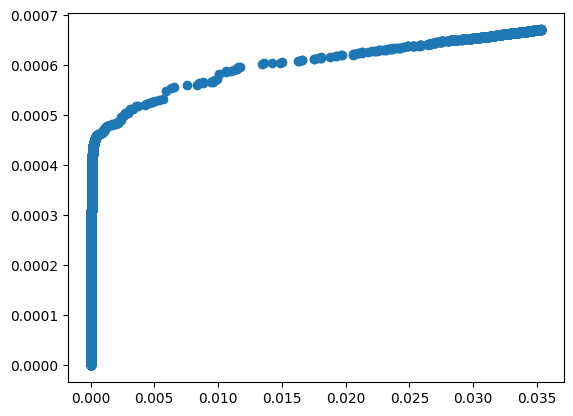

In [28]:
plt.scatter(y_pred_kdc_test[:,9][y_pred_kdc_test[:,9].argsort()], y_pred_test[:,9][y_pred_test[:,9].argsort()])

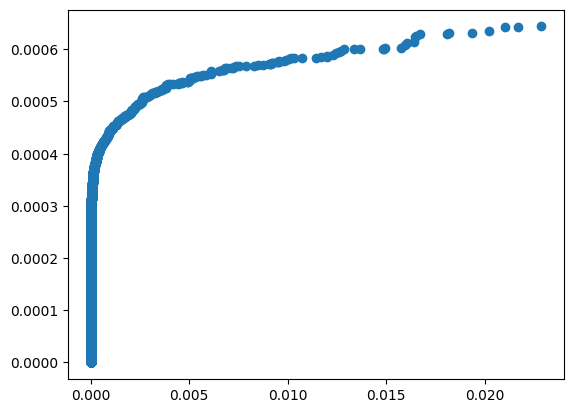

In [29]:
plt.scatter(y_pred_kdc_uniform[:,9][y_pred_kdc_uniform[:,9].argsort()], y_pred_uniform[:,9][y_pred_uniform[:,9].argsort()])

## Baseline model: Mixed QMC variational, ZZFM, with Le-Net Conv layer with HEA, Discriminative then generative learning, additional linear layer from dim of latent space to dim 4.

The number of parameters of the Hardware efficient ansatz is given by,


```
HEA_size = n_qubits * (num_layers_hea + 1) * 2
```



In [10]:
### Quantum variational KDC with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)

class VQKDC_MIXED_ZZFM_HEA_LENET:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, dim_lenet_out_param,  input_dim_param, gamma, n_training_data, num_zzfm_layers, reduction = "none", training_type = "generative", num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_zzfm_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_zzfm_qubits + self.n_ancilla_qubits
        self.n_training_data = n_training_data
        self.dim_lenet_out = dim_lenet_out_param
        self.input_dim = input_dim_param
        self.num_zzfm_layers = num_zzfm_layers
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.reduction  = reduction
        self.training_type = training_type
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        ## build the Let-net model
        #self.model = Sequential() ## keep for old code
        self.model = Sequential() ## new code
        self.model.add(tf.keras.layers.InputLayer(input_shape=(self.input_dim, self.input_dim, 1))) ## new code
        #self.model.add(tf.keras.layers.Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(self.input_dim, self.input_dim, 1))) # keep for old code
        self.model.add(tf.keras.layers.Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation='relu')) ## new code
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(5, 5), padding="same", activation='relu'))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=84, activation='relu'))
        self.model.add(tf.keras.layers.Dense(units=self.dim_lenet_out, activation = 'relu')) # original "softmax"
        self.model.add(tf.keras.layers.Dense(units=self.n_zzfm_qubits, activation = None))  ## we add this additional layer compared to normal models

        # add the quantum layer

        self.model.add(layer)
        print(self.model.summary())

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices classes, of ms
        n_qubits_classes_zzfm_temp = self.num_classes_qubits + self.n_zzfm_qubits
        index_qubit_states = _indices_qubits_classes(n_qubits_classes_zzfm_temp, self.num_classes) # extract indices of the bit string of classes

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict zzfm
        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        for i in range(self.num_zzfm_layers):
          for k in reversed(range(self.n_zzfm_qubits)):
            for j in reversed(range(0, k)):
              self.circuit.cnot(init_qubit_qeff_temp + j, init_qubit_qeff_temp + k)
              self.circuit.rz(init_qubit_qeff_temp + k, theta = 2*(math.pi-x_sample_temp[0][j])*(math.pi-x_sample_temp[0][k]))
              self.circuit.cnot(init_qubit_qeff_temp + j, init_qubit_qeff_temp + k)

          for l in range(self.n_zzfm_qubits):
            self.circuit.rz(init_qubit_qeff_temp + l, theta = 2*(x_sample_temp[0][l]))

          for m in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_zzfm_qubits):
            self.circuit.H(m)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_zzfm_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        if self.training_type == "discriminative":
          measurements_results = measurements_results / tf.reduce_sum(measurements_results, axis = -1)
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
      ## code generated with the aid of chat gpt
      """
      Compute the categorical cross-entropy loss with mean reduction.

      Args:
      y_true: Tensor of true labels, shape (batch_size, num_classes).
      y_pred: Tensor of predicted probabilities, shape (batch_size, num_classes).

      Returns:
      Scalar tensor representing the mean loss over the batch.
      """
      # Ensure predictions are clipped to avoid log(0)
      epsilon_two = 1e-7  # small constant to avoid division by zero
      y_pred = tf.clip_by_value(y_pred, epsilon_two, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon

      # Compute the categorical cross-entropy loss for each sample
      loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

      if self.reduction == "none":
        return loss
      elif self.reduction == "mean":
        # Compute the mean loss over the batch
        mean_loss = tf.reduce_mean(loss)
        return mean_loss
      elif self.reduction == "sum":
        # Compute the sum loss over the batch
        sum_loss = tf.reduce_sum(loss)
        return sum_loss
      else:
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.Adam,
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_lenet_out/2.)*\
          self.model.predict(x_test)).numpy()

    def extract_lenet_features(self, x_test):
      r"""
      Method to extract the features of the Lenet.

      Args:
          x_test:

      Returns:
          Features of the Lenet.
      """
      extract = Model(self.model.inputs, self.model.layers[-2].output)
      new_model = Sequential()
      new_model.add(extract)
      return new_model.predict(x_test)

    def freeze_lenet(self):
      r"""
      Method to frezze the layers of the Lenet.

      Args:
          self:

      Returns:
          None.
      """
      for layer in self.model.layers[:-1]:
          layer.trainable = False

    def set_training_type(self, new_training_type):
      r"""
      Method to change the training type of the method during training.

      Args:
          new_training_strategy:

      Returns:
          None.
      """
      self.training_type = new_training_type

In [11]:
class VQKDC_MIXED_ZZFM_HEA:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_zzfm_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, n_training_data, num_zzfm_layers, reduction = "none", training_type = "generative", num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, auto_compile=True):

        self.circuit = None
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_zzfm_qubits = n_zzfm_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_zzfm_qubits + self.n_ancilla_qubits
        self.n_training_data = n_training_data
        self.num_zzfm_layers = num_zzfm_layers
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.reduction  = reduction
        self.training_type = training_type
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices classes, of ms
        n_qubits_classes_zzfm_temp = self.num_classes_qubits + self.n_zzfm_qubits
        index_qubit_states = _indices_qubits_classes(n_qubits_classes_zzfm_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict zzfm
        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        for i in range(self.num_zzfm_layers):
          for k in reversed(range(self.n_zzfm_qubits)):
            for j in reversed(range(0, k)):
              self.circuit.cnot(init_qubit_qeff_temp + j, init_qubit_qeff_temp + k)
              self.circuit.rz(init_qubit_qeff_temp + k, theta = 2*(math.pi-x_sample_temp[0][j])*(math.pi-x_sample_temp[0][k]))
              self.circuit.cnot(init_qubit_qeff_temp + j, init_qubit_qeff_temp + k)

          for l in range(self.n_zzfm_qubits):
            self.circuit.rz(init_qubit_qeff_temp + l, theta = 2*(x_sample_temp[0][l]))

          for m in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_zzfm_qubits):
            self.circuit.H(m)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_zzfm_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        if self.training_type == "discriminative":
          measurements_results = measurements_results / tf.reduce_sum(measurements_results, axis = -1)
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
      ## code generated with the aid of chat gpt
      """
      Compute the categorical cross-entropy loss with mean reduction.

      Args:
      y_true: Tensor of true labels, shape (batch_size, num_classes).
      y_pred: Tensor of predicted probabilities, shape (batch_size, num_classes).

      Returns:
      Scalar tensor representing the mean loss over the batch.
      """
      # Ensure predictions are clipped to avoid log(0)
      epsilon_two = 1e-7  # small constant to avoid division by zero
      y_pred = tf.clip_by_value(y_pred, epsilon_two, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon

      # Compute the categorical cross-entropy loss for each sample
      loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

      if self.reduction == "none":
        return loss
      elif self.reduction == "mean":
        # Compute the mean loss over the batch
        mean_loss = tf.reduce_mean(loss)
        return mean_loss
      elif self.reduction == "sum":
        # Compute the sum loss over the batch
        sum_loss = tf.reduce_sum(loss)
        return sum_loss
      else:
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.Adam,
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return self.model.predict(x_test)

In [12]:
## training the quantum circuit
# Define a LeNet CNN feature extraction model
input_shape = X_train.shape[1:]
INPUT_DIM = input_shape[0]
NUM_QUBITS_FFS = 4 ## originally N_QEFFS = 16
NUM_CLASSES = 10
NUM_CLASSES_QUBITS = 4
DIM_LENET_OUT = 30 # originally 16
GAMMA = 2**(-2) ## originally 2**(0)
EPOCHS = 4
N_TRAINING_DATA = X_train.shape[0]
BATCH_SIZE = 16
NUM_ZZFM_LAYERS = 2 ## set 2 for final experiments
LEARNING_RATE = 0.0005 ## originally 0.0005
RANDOM_STATE_QEFF = 123
NUM_ANCILLA_QUBITS = 1
NUM_TOTAL_QUBITS = NUM_QUBITS_FFS + NUM_ANCILLA_QUBITS + NUM_CLASSES_QUBITS
NUM_LAYERS_HEA = int(np.round(((2**NUM_TOTAL_QUBITS-1)/NUM_TOTAL_QUBITS)-1))
TRAINING_TYPE = "generative"
REDUCTION = "none"

In [13]:
## this code creates a discriminative model
vqkdc_zzfm_hea_lenet = VQKDC_MIXED_ZZFM_HEA_LENET(n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, dim_lenet_out_param = DIM_LENET_OUT, input_dim_param = INPUT_DIM, gamma=GAMMA, n_training_data = N_TRAINING_DATA, num_zzfm_layers = NUM_ZZFM_LAYERS, reduction = REDUCTION, training_type = TRAINING_TYPE, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, auto_compile = False)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
vqkdc_zzfm_hea_lenet.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
vqkdc_zzfm_hea_lenet.fit(X_train, y_train_oh, epochs = EPOCHS)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 20)          │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          25,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 7, 7, 50)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2450)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │         205,884 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ quantum_layer (QuantumLayer)         │ (None, 10)                  │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,154 (922.58 KB)

 Trainable params: 235,154 (922.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1272s 229ms/step - accuracy: 0.6977 - loss: 1.2088
Epoch 2/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 874s 233ms/step - accuracy: 0.9773 - loss: 0.2016
Epoch 3/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 922s 233ms/step - accuracy: 0.9872 - loss: 0.1012
Epoch 4/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 911s 230ms/step - accuracy: 0.9912 - loss: 0.0668


In [14]:
# Create a model only for feature extraction with intermediate sigmoid activation
extract = tf.keras.Model(vqkdc_zzfm_hea_lenet.model.inputs, vqkdc_zzfm_hea_lenet.model.layers[-2].output)
print(extract.summary())

X_train_feats = extract.predict(X_train)
X_test_feats = extract.predict(X_test)

X_train_feats.shape, X_test_feats.shape

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 20)          │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          25,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 7, 7, 50)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2450)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │         205,884 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 234,128 (914.56 KB)

 Trainable params: 234,128 (914.56 KB)

 Non-trainable params: 0 (0.00 B)

None
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


((60000, 4), (10000, 4))

In [55]:
## create uniform points around the space of data for out-of-distribution density estimation and select gamma for such ds

np.random.seed(3)
X_uniform_feats = np.random.uniform(X_train_feats.min(axis=0), X_train_feats.max(axis=0), size=(10000, 4))
sigma_temp = (1/16)*((X_train_feats.max(axis=0)- X_train_feats.min(axis=0)).max())
gamma_temp = 2**int(np.log2(1/(2*(sigma_temp**2))))

X_uniform_feats.shape, X_train_feats.max(axis=0), X_train_feats.min(axis=0), X_uniform_feats[:2, :], gamma_temp, sigma_temp, (X_train_feats.max(axis=0)- X_train_feats.min(axis=0)).max()

((10000, 4),
 array([ 0.4785696 ,  0.3096212 ,  0.14740668, -0.2382832 ], dtype=float32),
 array([ 0.01507727, -0.01309472, -0.15235911, -0.74459654], dtype=float32),
 array([[ 0.27036787,  0.21543587, -0.06515582, -0.48595771],
        [ 0.42895133,  0.27615334, -0.11471293, -0.63966671]]),
 256,
 0.031644582748413086,
 0.5063133)

In [16]:
del extract
del vqkdc_zzfm_hea_lenet

In [17]:
import gc

# Call garbage collector
gc.collect()

710

In [26]:
## training the VQKDC quantum circuit with features in a generative way
vqkdc_zzfm_hea = VQKDC_MIXED_ZZFM_HEA(dim_x_param = NUM_QUBITS_FFS, n_zzfm_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, num_zzfm_layers = NUM_ZZFM_LAYERS, reduction = REDUCTION, training_type = TRAINING_TYPE, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE)
vqkdc_zzfm_hea.fit(X_train_feats, y_train_oh, epochs = EPOCHS)

Epoch 1/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1487s 209ms/step - accuracy: 0.6870 - loss: 3.2097
Epoch 2/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 741s 198ms/step - accuracy: 0.9910 - loss: 2.3562
Epoch 3/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 739s 197ms/step - accuracy: 0.9907 - loss: 2.3396
Epoch 4/4
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 746s 198ms/step - accuracy: 0.9898 - loss: 2.3340


In [27]:
print(vqkdc_zzfm_hea.model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ quantum_layer_2 (QuantumLayer)       │ (16, 10)                    │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,080 (24.06 KB)

 Trainable params: 1,026 (8.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,054 (16.04 KB)

None


In [30]:
y_pred_test = vqkdc_zzfm_hea.predict(X_test_feats)
y_pred_uniform = vqkdc_zzfm_hea.predict(X_uniform_feats)

accuracy_score(y_test, np.argmax(y_pred_test, axis=1)), y_pred_uniform.shape, y_pred_test.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step


(0.9864, (10000, 10), (10000, 10))

In [47]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values by using the class priors
y_pred_kdc_test = kernel_density_classification(X_train_feats, y_train_oh, X_test_feats, gamma_param = gamma_temp)

spearman_corr_classes = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes[i] = spearmanr(y_pred_test[:, i], y_pred_kdc_test[:, i])[0]*(y_train_oh_array[:, i].sum()/len(y_train_oh_array))

spearman_corr_classes, spearman_corr_classes.sum()

(array([0.07941137, 0.0984115 , 0.08295008, 0.07127854, 0.04402786,
        0.05668464, 0.07900523, 0.08728725, 0.07193214, 0.07212066]),
 0.7431092583112067)

In [48]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values by using the class priors
y_pred_kdc_uniform = kernel_density_classification(X_train_feats, y_train_oh, X_uniform_feats, gamma_param = gamma_temp)

spearman_corr_classes_uniform = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes_uniform[i] = spearmanr(y_pred_uniform[:, i], y_pred_kdc_uniform[:, i])[0]*(y_train_oh_array[:, i].sum()/len(y_train_oh_array))

spearman_corr_classes_uniform, spearman_corr_classes_uniform.sum()

(array([4.26704187e-02, 4.80755804e-02, 1.78605736e-02, 3.89682640e-02,
        7.68128180e-05, 4.41967773e-02, 4.76932727e-02, 4.28354185e-02,
        5.18676388e-02, 4.27307092e-02]),
 0.37697546616544264)

In [49]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values with average of SPR
#y_pred_kdc_test = kernel_density_classification(X_train_feats, y_train_oh, X_test_feats, gamma_param = gamma_temp)

spearman_corr_classes = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes[i] = spearmanr(y_pred_test[:, i], y_pred_kdc_test[:, i])[0]*(1./10.)

spearman_corr_classes, spearman_corr_classes.sum()

(array([0.08044373, 0.08758069, 0.08353482, 0.06975554, 0.04521862,
        0.06273894, 0.08009993, 0.08359513, 0.07376395, 0.07273894]),
 0.739470287077503)

In [50]:
# Calculate spearmann correlation per class for qeff mapping, i.e., the ranks of the density values with average of SPR
#y_pred_kdc_uniform = kernel_density_classification(X_train_feats, y_train_oh, X_uniform_feats, gamma_param = gamma_temp)

spearman_corr_classes_uniform = np.zeros(10)
y_train_oh_array = np.array(y_train_oh)

for i in range(10):

  # Calculate the Spearman correlation
  spearman_corr_classes_uniform[i] = spearmanr(y_pred_uniform[:, i], y_pred_kdc_uniform[:, i])[0]*(1./10.)

spearman_corr_classes_uniform, spearman_corr_classes_uniform.sum()

(array([4.32251414e-02, 4.27845569e-02, 1.79864790e-02, 3.81356360e-02,
        7.88902616e-05, 4.89172964e-02, 4.83541123e-02, 4.10235453e-02,
        5.31884862e-02, 4.30970340e-02]),
 0.3767911776107118)

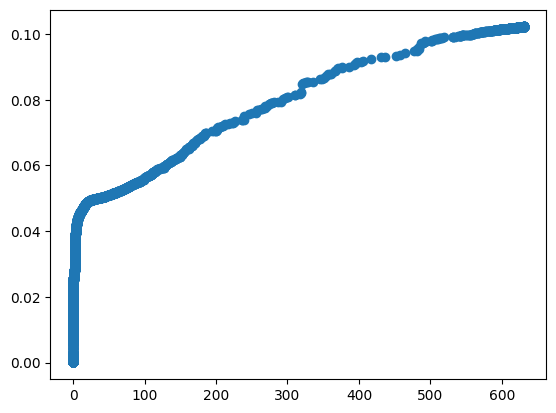

In [51]:
plt.scatter(y_pred_kdc_test[:,9][y_pred_kdc_test[:,9].argsort()], y_pred_test[:,9][y_pred_test[:,9].argsort()])

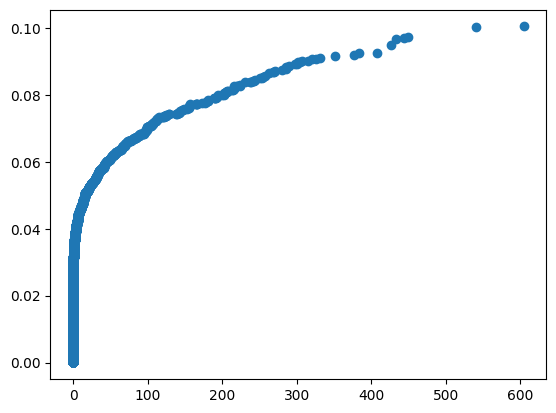

In [52]:
plt.scatter(y_pred_kdc_uniform[:,9][y_pred_kdc_uniform[:,9].argsort()], y_pred_uniform[:,9][y_pred_uniform[:,9].argsort()])